In [29]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm

In [ ]:
df = pd.read_csv('earnings.csv', sep=';')
col_names = list(df.columns)

df.info()

for col in col_names:
  unique_list = sorted(df[col].unique())
  unique_list = [str(x) for x in unique_list]
  print(col, ": ", unique_list[:5], " ", unique_list[-5:])

df.describe()

## Opis danych

W naszym zbiorze danych mamy `15` kolumn, `11000` obserwacji.

Kolumny `base`, `bonus`, `overtime_pay`, `other`, `duration_total`, `duration_entity`, `duration_nominal`, `duration_overtime` będziemy traktować jako zmienne **ilościowe**.

Natomiast kolumny `sector`, `section_07`, `sex`, `education` `contract`, `age` będziemy traktować jako zmienne **jakościowe**.

W zbiorze nie ma żadnych brakujących danych, co sprawdziliśmy poprzez `df.info()` i unikalne wartości dla każdej kolumny.

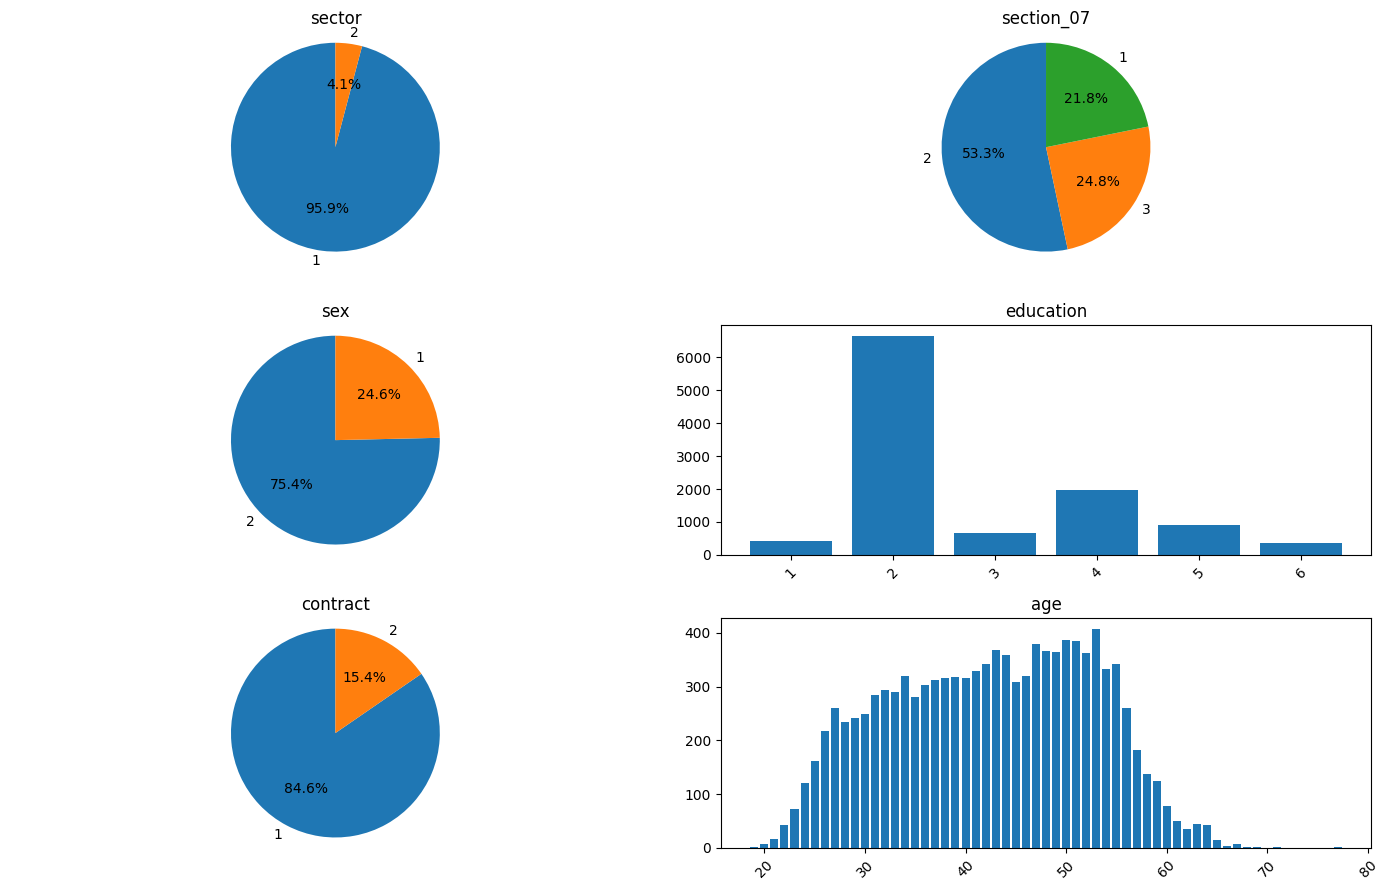

In [31]:
quantitative_cols = ['base', 'bonus', 'overtime_pay', 'other', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']
qualitative_cols = ['sector', 'section_07', 'sex', 'education', 'contract', 'age']
plot_kind = ['pie', 'pie', 'pie', 'bar', 'pie', 'bar']

rows = 3
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(14, 9))

ax_ind = []

for i in range(rows):
  for j in range(cols):
    ax_ind.append((i, j))

i = 0
for col_name in qualitative_cols:
  counts = df[col_name].value_counts();

  row = ax_ind[i][0]
  col = ax_ind[i][1]

  if plot_kind[i] == 'pie':
    ax[row, col].pie(
        counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=90
    )
    ax[row][col].set_title(col_name)
    ax[row][col].axis('equal')  # żeby było okrągłe
  else:
    bars = ax[row, col].bar(counts.index, counts.values)
    ax[row, col].set_title(col_name)
    ax[row, col].tick_params(axis='x', rotation=45)

  i += 1

plt.tight_layout()
plt.show()

## Opis wykresów częstości

W naszym zbiorze danych jeśli chodzi o:

* sektor: jedynie `4,1%` wszystkich obserwacji należy do sektora prywatnego, pozostałe obserwacje należą do sektora publicznego
* sekcję NACE (`section_07`):
  * ponad połowę obserwacji stanowią osoby z sekcji edukacyjnej (`Education`) - `53,3%`
  * pozostała połowa dzieli się mniej więcej po równo: sekcje `Public Administration and Defence; Compulsory Social Security` - `21,8%` i sekcja `Human Health and Social Work Activities` - `24,8%`
* płeć: jedynie `24,6%` wszystkich obserwacji stanowią mężczyźni, a kobiety `75,4%`
* kontrakt: `15,4%` obserwacji stanowią osoby zatrudnione na czas określony, a osoby zatrudnione na czas nieokreślony `84,6%`
* wykształcenie:
  * znaczna większość osób zatrudnionych posiada wykształcenie wyższe
  * po nich najwięcej jest osób z wykształceniem średnim
  * najmniej osób jest z wykształceniem podstawowym
* wiek:
  * najwięcej osób zatrudnionych jest w wieku od `50` do `55` lat
  * po wieku `55` lat można zauważyć szybki spadek liczby zatrudnionych - im wyższy wiek, tym mniej osób zatrudnionych w tym wieku
  * wśród osób w wieku od `20` do `28` lat liczba osób zatrudnionych szybko rośnie wraz z wyższym wiekiem
  * wśród osób w wieku od `28` do `50` lat liczba osób zatrudnionych powoli rośnie wraz z wyższym wiekiem

Podane powyżej procenty są przybliżeniem rzeczywistych procentów do jednego miejsca po przecinku.

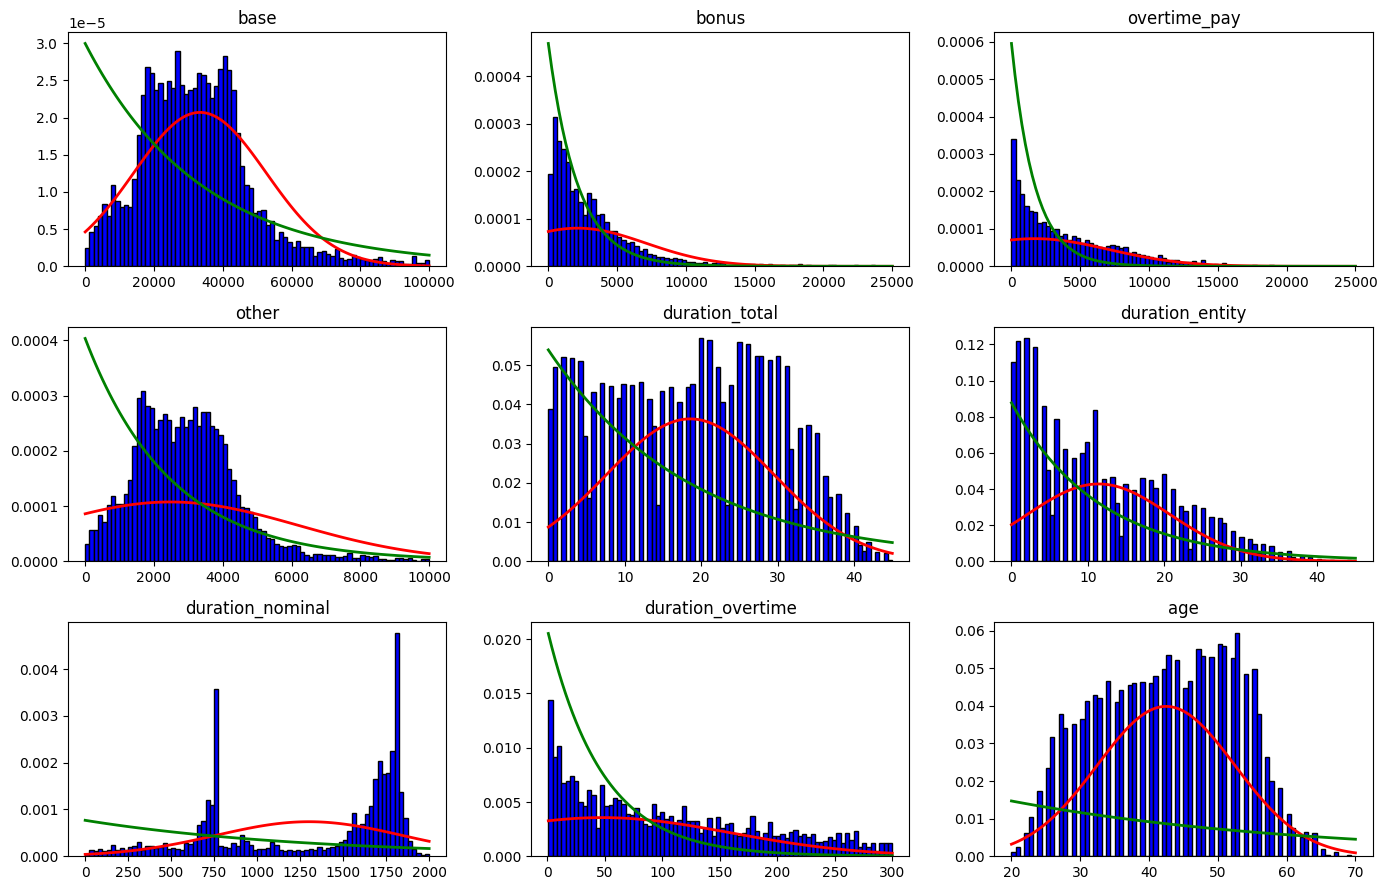

In [32]:
col_names = quantitative_cols + ['age']
xlims = {
    'base': (0, 100000),
    'bonus': (1, 25000),
    'overtime_pay': (1, 25000),
    'other': (1, 10000),
    'duration_total': (0, 45),
    'duration_entity': (0, 45),
    'duration_nominal': (0, 2000),
    'duration_overtime': (1, 300),
    'age': (20, 70)
    }

rows = 3
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(14, 9))

ax_ind = []

for i in range(rows):
  for j in range(cols):
    ax_ind.append((i, j))

i = 0
for col_name in col_names:
  counts = df[col_name].value_counts();

  row = ax_ind[i][0]
  col = ax_ind[i][1]

  x_min = xlims[col_name][0]
  x_max = xlims[col_name][1]

  ax[row, col].hist(
      df[col_name],
      bins=80, color='blue',
      edgecolor='black',
      range=(x_min, x_max),
      density=True
      )

  mu, std = np.mean(df[col_name]), np.std(df[col_name])

  # Obliczanie wartości PDF dla rozkładu normalnego
  x = np.linspace(x_min, x_max, 100)
  normal_pdf = stats.norm.pdf(x, mu, std)

  ax[row, col].plot(x, normal_pdf, color='red', linewidth=2, label='Normalny Rozkład')

  lambda_param = 1 / np.mean(df[col_name])

  # Obliczanie wartości PDF dla rozkładu wykładniczego
  x = np.linspace(x_min, x_max, 100)
  exp_pdf = stats.expon.pdf(x, scale=1/lambda_param)

  # Rysowanie rozkładu wykładniczego
  ax[row, col].plot(x, exp_pdf, color='green', linewidth=2, label='Wykładniczy Rozkład')


  ax[row, col].set_title(col_name)

  i += 1

plt.tight_layout()
plt.show()

## Histogramy zmiennych ilościowych i niektórych jakościowych

Wszystkie histogramy zostały znormalizowane tak, aby można było je porównywać z funkcjami gęstości.

* `base`
  * nie widać tu podobieństwa ani do rozkładu wykładniczego, ani do rozkładu normalnego
  * widać też, że tzw. widełki wynagrodzenia mieszczą się w przedziale `[19000, 43000]`, a jest to dość duży przedział w porównaniu do przedziału wszystkich płac, więc to wydaje się normalne, że nie ma tu podobieństwa do rozkładu wykładniczego i normalnego
* `bonus`
  * w tym histogramie nie zostały uwzględnione obserwacje, dla których bonus wynosi `0`, ponieważ takich jest bardzo dużo w porównaniu do reszty obserwacji
  * widać podobieństwo do rozkładu wykładniczego
* `overtime_pay`
  * w tym histogramie nie zostały uwzględnione obserwacje, dla których bonus wynosi `0`, ponieważ takich jest bardzo dużo w porównaniu do reszty obserwacji
  * widać podobieństwo do rozkładu wykładniczego
* `other`
  * brak podobieństwa do rozkładu normalnego i wykładniczego
  * widać podobieństwo do rozkładu `base`
* `duration_total`
  * brak podobieństwa do rozkładu normalnego i wykładniczego
  * jest lekkie podobieństwo do rozkładu jednostajnego dyskretnego, co może świadczyć o tym, że każdego roku jest zatrudniana podobna ilość pracowników
  * jednak widać, że dla niektórych wartości obserwacji jest mniej, co może świadczyć, np. o pojawieniu się lepszych ofert pracy akurat tego roku, czy może zmianie zarządu, która dla niektórych pracowników mogła być niekorzystna
  * widać też, że dla niektórych wartośc obserwacji jest więcej, co może świadczyć o tym, że akurat gdy ci pracownicy byli zatrudniani była też większa potrzeba większej ilości pracowników
* `duration_entity`
  * widać lekkie podobieństwo do rozkładu wykładniczego
  * czyli można wywnioskować, że w jednostce sprawozdawczej (`reporting entity`) im dłuższy okres zatrudnienia, tym mniej jest on prawdopodobny
* `duration_nominal`
  * brak podobieństwa do rozkładu normalnego i wykładniczego
  * widać szczególnie 2 miejsca, w których słupki są znacząco wysokie - pewnie odnosi się to do tego, że są zwykle dostępne 2 wymiary godzinowe pracy - pełny etat i pół etatu
* `duration_overtime`
  * podobieństwo do rozkładu wykładniczego
  * czyli można wywnioskować, że dłuższa praca nadgodzinowa jest mniej prawdopodobna
* `age`
  * brak podobieństwa wykładniczego
  * małe podobieństwo do rozkładu normalnego
  * w stosunkowo młodym wieku im większy wiek, tym większe prawdopodobieństwo zatrudnienia, natomiast później wiek nie odgrywa aż tak istotnego znaczenia, dopiero po wieku ok. `55` lat liczba osób zatrudnionych szybko spada

## Clustering

### Co próbujemy przeanalizować?

Do analizy skupień wybrałem zmienne `base` i `bonus`, ponieważ możnaby zadać sobie pytanie: kto ma większą motywację do większego wkładu w pracę, żeby otrzymywać bonusy, osoby, których wynagrodzenie jest standardowe, czy może osoby z wyższym wynagrodzeniem, czy może w ogóle nie jest to od siebie zależne?

Trzeba się zastanowić, czy wartości, w którejś zmiennej nie byłoby dobrze przeskalować. Tutaj jest to zależne od tego, co nas interesuje. W zmiennej `bonus` wiemy, że mogą to być bonusy ustawowe, czyli zapewne takie, o których z góry wiadomo za co się je dostaje i reguły co do nich są jasno zdefiniowane, nagrody i bonusy "uznaniowe", czyli takie, o których może być z góry nie wiadomo, czy będą przyznane i w jakiej kwocie.

Przez to, że nie jest to rozdzielone na te bonusy, o których wcześniej wiadomo i te, o których wcześniej nie wiadomo trudno tutaj wnioskować, czy to, że dana osoba go dostała to znaczy, że o niego się starała, czy nie. Ponadto różne typy bonusów są różnej wielkości, więc dodatkową motywacją w niektórych bonusach może być to, że są na przykład wysokie.

Niemniej jednak dla uproszczenia zbadajmy to, czy wysokość standardowego wynagrodzenia wpływa w jakiś sposób na bonusy. Pomińmy tutaj wielkość bonusów, ponieważ osoby na ważniejszych stanowiskach zarabiają zwykle więcej i dodatkowo bonusy dostępne dla ich stanowisk mogą być wyższe ze względu na istotność tych stanowisk.

### Przygotowanie danych i narysowanie dendrogramu

W związku z tym przeskalujemy wartości w zmiennej `bonus`. Co za tym idzie, wielkość bonusu nie będzie już tak bardzo istotna. Istotna będzie bardziej relacja pomiędzy bonusami (większe, mniejsze), więc będzie to tylko informacja jak wysokie bonusy w porównaniu z innymi możliwymi dana osoba uzyskała.

Zmiennej `base` wolałbym nie skalować, ponieważ w porównaniu do bonusów, wysokość stałego wynagrodzenia odgrywa dużo ważniejszą rolę w podejściu danej osoby do pracy. Poza tym histogram zmiennej `base` pokazuje, że skalowanie nie jest tak bardzo potrzebne, bo bardzo duży osób ma stałe wynagrodzenie w jakichś widełkach, a bardzo niskie i bardzo wysokie wynagrodzenia mają tylko nieliczne grupy osób.

In [ ]:
scaler = StandardScaler()

two_features = df[['base', 'bonus']].copy()

scaled = scaler.fit_transform(two_features)

two_features = pd.DataFrame(scaled, columns=two_features.columns)

clustering = hierarchy.linkage(two_features, method='ward')
print(hierarchy.dendrogram(clustering))

{'icoord': [[5.0, 5.0, 15.0, 15.0], [35.0, 35.0, 45.0, 45.0], [25.0, 25.0, 40.0, 40.0], [10.0, 10.0, 32.5, 32.5], [65.0, 65.0, 75.0, 75.0], [55.0, 55.0, 70.0, 70.0], [95.0, 95.0, 105.0, 105.0], [85.0, 85.0, 100.0, 100.0], [62.5, 62.5, 92.5, 92.5], [21.25, 21.25, 77.5, 77.5], [125.0, 125.0, 135.0, 135.0], [115.0, 115.0, 130.0, 130.0], [145.0, 145.0, 155.0, 155.0], [165.0, 165.0, 175.0, 175.0], [150.0, 150.0, 170.0, 170.0], [195.0, 195.0, 205.0, 205.0], [185.0, 185.0, 200.0, 200.0], [160.0, 160.0, 192.5, 192.5], [122.5, 122.5, 176.25, 176.25], [225.0, 225.0, 235.0, 235.0], [215.0, 215.0, 230.0, 230.0], [245.0, 245.0, 255.0, 255.0], [265.0, 265.0, 275.0, 275.0], [250.0, 250.0, 270.0, 270.0], [222.5, 222.5, 260.0, 260.0], [315.0, 315.0, 325.0, 325.0], [305.0, 305.0, 320.0, 320.0], [295.0, 295.0, 312.5, 312.5], [285.0, 285.0, 303.75, 303.75], [345.0, 345.0, 355.0, 355.0], [335.0, 335.0, 350.0, 350.0], [294.375, 294.375, 342.5, 342.5], [241.25, 241.25, 318.4375, 318.4375], [149.375, 149.375,

Tutaj widzimy, że wysokość prawego poddrzewa jest wyższa niż lewego. Może to oznaczać, że te punkty z prawej odnogi są dalej od siebie położone.

### Metoda połączeń

W analizie skupień bazując na zmiennych `base` i `bonus` wybrałem metodę połączeń **ward**, ponieważ ta metoda działa dobrze na danych liczbowych, z którymi mamy do czynienia i minimalizuje przyrost wariancji wewnątrz klastrów.

W tym przypadku metoda *single* nie byłaby odpowiednia, bo nie widać tutaj łańcuchów, które mogłyby być połączone w jeden klaster.

Metoda *complete* byłaby w miarę dobra, ale zignorowałaby klaster czerwony, który w mojej opinii wyznacza ważną grupę *outlier'ów* i raczej próbowała by go włączyć do np. klastra żółtego. Poza tym, mamy sporo *outlier'ów*, które mogłyby zaburzać wynik. (np. jedna obserwacja przez bycie *outlier'em* mogłaby być włączona w oddzielny klaster, przez to, że byłaby "daleko" od pozostałych obserwacji).

Metoda *average* jest kompromisem między *single* i *complete*, ale jako, że *single* w ogóle w tym przypadku nie byłaby dobra, to taki kompromis również nie byłby dobry.

Zatem w mojej opinii najlepsza jest tutaj metoda **ward**, z której możemy wyciągnąć najwięcej wniosków o powstałych klastrach.

In [ ]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(two_features)
labels = clustering.labels_

fig = px.scatter(two_features, x="base", y="bonus", color=labels, title="Agglomerative Clastering for 3 clusters (the best according to dendrogram)")
fig.show()

### Silhuoette score

Silhouette score jest wyższy dla `2` klastrów, ale silhouette score wyznacza lepszą średnią seprację, więc może zdarzać się tak (tak jak w tym przypadku), że ignoruje mniejsze grupy (tak jak ta czerwona w tym przypadku), więc akurat moim zdaniem bardziej odpowiednia liczba klastrów to `3` przez to, że możemy z tego wyciągnąć więcej wniosków o klastrach (co też zaraz będziemy mogli zobaczyć)

In [ ]:
for k in range(2, 14):
  clustering = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(two_features)
  labels = clustering.labels_
  silhouette_avg = silhouette_score(two_features, labels)
  print(f"Liczba klastrów: {k}, Współczynnik Silhouette: {silhouette_avg}")

In [ ]:
clustering = AgglomerativeClustering(n_clusters=2, linkage="ward").fit(two_features)
labels = clustering.labels_

fig = px.scatter(two_features, x="base", y="bonus", color=labels, title="Agglomerative Clastering for 3 clusters (the best according to silhouette score)")
fig.show()

### Rezultaty

Utworzyły się `3` klastry. Niebieski możnaby nazwać klastrem osób, które zarabiają standardowo i do tego dostały stosunkowo niskie bonusy. Klaster żółty, to osoby, które albo zarabiają więcej jeśli chodzi o swoją stałę stawkę, albo dostały wysokie bonusy, albo to i to. Klaster czerwony to osoby, które wyróżniły się zdecydowanie wysokim bonusem.

W wykresach powyżej widać też, że wyższe bonusy zostały uzyskane przez osoby o wyższych wynagrodzeniach.

Przy `2` klastrach obserwacje możemy podzielić na te, w których osoby mają niskie lub średnie wynagrodzenie i udało im się uzyskać jedynie niskie bonusy oraz na te, którym udało się uzyskać wyższe bonusy lub zarabiają więcej, lub to i to.

## Classification

In [ ]:
feature_names = ['base', 'duration_total', 'duration_nominal']
base = np.array(df[feature_names])
classes = np.array(df['education'])

print(base.shape)

print(np.unique(classes))

higher = 1
nonhigher = 0

for i in range(len(classes)):
  if classes[i] in {1, 2}:
    classes[i] = 1
    higher += 1
  else:
    classes[i] = 0
    nonhigher += 1

print(higher, nonhigher)
print(higher / nonhigher)
print(higher / (nonhigher + higher))

print(np.unique(classes))

xtrain, xtest, ytrain, ytest = train_test_split(base, classes, test_size=0.2, random_state=42)

lr = LogisticRegression().fit(xtrain, ytrain)

In [ ]:
scores = cross_val_score(lr, base, classes, cv=5)

print(scores)
print(f"Średnia dokładność: {np.mean(scores)}")

Średnia dokładność przy cross walidacji to ok. `0,85`. Jest to całkiem dobry wynik, jednak sugeruje, że model może czasem się mylić.

In [ ]:
ypred = lr.predict(xtest)
cm = confusion_matrix(ytest, ypred)
f1 = f1_score(ytest, ypred)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print(f"True positive: {tn}")
print(f"True negative: {tn}")
print(f"False positive: {fp}")
print(f"False negative: {fn}")

print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
print(f"Precision: {tp / (tp + fp)}")
print(f"Recall: {tp / (tp + fn)}")
print(f"Specificity: {tn / (tn + fp)}")
print(f"f1 score {f1}")

Zauważamy, że nasze klasy (wykształcenie wyższe vs. reszta) nie są zrównoważone. Osób z wykształceniem wyższym jest ok. `1,8` razy więcej niż tych, którzy nie mają wykształcenia wyższego.

Jest to istotne, ponieważ w zależności od zrównoważenia zbioru można wyciągać różne wnioski. Nasza *dokładność* wynosi `0,85`, ale przez to, że jedna klasa jest dużo większa od drugiej, to ta miara nie jest aż tak istotna, ponieważ model może dobrze przewidywać większą klasę i osiągnąć poprzez to wysoką dokładność.

Mamy *precyzję* `0,88` i *czułość* (*recall*) `0,89`. *Precyzja* mówi jaki odsetek obserwacji wśród obserwacji zakwalifikowanych jako pozytywnie jest prawdziwie pozytywnych, a *czułość* jaki odsetek spośród wszystkich pozytywnych obserwacji zostało rzeczywiście zakwalifikowanych jako obserwacje pozytywne.

Gdyby czułość była mniejsza o ok. 25 punktów procentowych, byłoby to już niepokojące, ponieważ klasa pozytywna stanowi 64% zbioru. W takiej sytuacji model byłby gorszy niż proste przypisywanie etykiety "positive" do każdej obserwacji. Precyzja `0,89` pokazuje, że wśród osób, które zostały zakwalifikowane jako osoby z wyższym wykształceniem, zdecydowana większość rzeczywiście ma wykształcenie wyższe.

*Specificzność*, czyli *True Negative Score* pokazuje nam, że ok. `77%` osób, które nie mają wykształcenia wyższego zostały dobrze zakwalifikowane. Jest to to trochę słabszy wynik w porównaniu do osób, które mają wyższe wykształcenie, ale nadal dobry.

*F1-score* jest dobre, gdy mamy do czynienia z nierównomiernymi klasami. Nie jest bardzo daleki od `1`, więc oznacza to, że model dobrze wykrywa klasę pozytywną i nie generuje zbyt wiele fałszywych alarmów.

Zatem jeśli chodzi o klasę osób z wyższym wykształceniem predykcja tego modelu działa dobrze, ale jeśli chodzi o klasę osób z wykształceniem innym niż wyższe jest trochę słabsza.

In [ ]:
coef = lr.coef_[0]
importance = pd.Series(coef, index=feature_names)

print(importance)

importance = importance.abs().sort_values(ascending=False)

print("Abs and sorted")
print(importance)

Największy wpływ spośród wybranych przeze mnie cech ma `duration_total`, następnie `duration_nominal` i co ciekawe `base` spośród tych trzech ma najmniejszy wpływ.

Wzrost `base` dla danej osoby nieznacznie zwiększa prawdopodobieństwo jej wykształcenia wyższego.

Wzrost `duration_nominal` nieznacznie zwiększa prawdopodobieństwo osoby na jej brak wykształcenia wyższego.

Wzrost `duration_total` zwiększa prawdopodobieństwo osoby na jej brak wykształcenia wyższego. (być może wynika to z tego, że osoby z dłuższym stażem to częściej osoby starsze i kiedyś być może trudniej było zdobyć wykształcenie wyższe lub nie było to tak popularne wśród społeczeństwa)

## Regression

In [ ]:
cat = ['sector', 'section_07', 'sex', 'education', 'contract']
num = ['bonus', 'overtime_pay', 'other', 'age', 'duration_total', 'duration_entity', 'duration_nominal', 'duration_overtime']

X = pd.DataFrame()

for col_name in cat:
  dummies = pd.get_dummies(df[col_name], prefix=col_name, drop_first=True, prefix_sep='_', dtype=int)
  X = pd.concat([X, dummies], axis=1)

concatenated = pd.concat([df[num], X], axis=1)

print(concatenated.columns)

X = np.array(concatenated)
Y = np.array(df['base'])

cols_to_drop = [8, 9]

X = np.delete(X, cols_to_drop, axis=1)

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

xtrain = sm.add_constant(xtrain)
xtest = sm.add_constant(xtest)

model = sm.OLS(ytrain, xtrain)
results = model.fit()
print(results.summary())

Spośród wszystkich możliwych zmiennych wyrzuciliśmy zmienne `duration_overtime` i `sector`, ponieważ *p-wartość* dla tych zmiennych była mniejsza niż `0,05`.

Rzeczywiście, możnaby było się spodziewać, że nadgodziny nie będą miał zbyt dużego wpływu na stałe wynagrodzenie pracownika. Jednak, co jest zastanawiające `ovetime_pay` ma *p-wartość* równą `0`, więc jest istotny, chociaż `duration_overtime` nie jest, a to wydaje się, że powinno iść w parze.

Sektor okazuje się, że nie jest istotny, więc nie wpływa raczej mocno na zarobki pracowników.

Jeśli chodzi o wpływ poszczególnych zmiennych na zarobki danego pracownika:

* wzrost `bonus` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `0,39` jednostek
* wzrost `overtime_pay` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `0,2856` jednostek
* wzrost `other` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `0,9685` jednostek
* wzrost `age` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `249,51` jednostek
* wzrost `duration_total` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `167,2637` jednostek
* wzrost `duration_entity` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `161,7885` jednostek
* wzrost `duration_nominal` o `1` jednostkę powoduje średni wzrost wynagrodzenia o `13.6143` jednostek
* jeśli obserwacja jest z `section_07` równym `Education`, to powoduje to średni wzrost wynagrodzenia o `7,3363`
* jeśli obserwacja jest z `section_07` równym `Human Health and Social Work Activities`, to powoduje to średni wzrost wynagrodzenia o `3277.9229`
* jeśli osoba jest kobietą, to powoduje to średni spadek wynagrodzenia o `2095.7113`
* jeśli osoba ma wykształcenie wyższe, to powoduje to średni spadek wynagrodzenia o `2116.4723`
* jeśli osoba ma wykształcenie policealne, to powoduje to średni spadek wynagrodzenia o `1.597e+04`
* jeśli osoba ma wykształcenie średnie, to powoduje to średni spadek wynagrodzenia o `1.929e+04`
* jeśli osoba ma wykształcenie `basic vocational`, to powoduje to średni spadek wynagrodzenia o `2.817e+04`
* jeśli osoba ma wykształcenie `middle school and below`, to powoduje to średni spadek wynagrodzenia o `2.923e+04`
* jeśli osoba ma umowę na czas określony, to powoduje to średni spadek wynagrodzenia o `5559.6044`